# Explore BBC Monitoring Corpus
Felix Zaussinger | 08.01.2021

## Core Analysis Goal(s)
1. Corpus Exploration
2. Descriptive statistics

## Key Insight(s)
1. Corpus needs some more cleaning, e.g., of single character tokens and other unmeaningful terms
2.
3.

## Sources
- https://textacy.readthedocs.io/en/stable/api_reference/lang_doc_corpus.html#textacy.corpus.Corpus

In [1]:
# magic commands
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# imports
import os
import re
import sys
import glob
import textacy
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import en_core_web_lg
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from textacy import preprocessing
from dotenv import find_dotenv, load_dotenv

# module settings
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

# logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

#### Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
model_dir = os.path.join(project_dir, "models")
figure_dir = os.path.join(project_dir, "reports", "figures")

#### Load and configure spacy nlp model

In [3]:
%%time
nlp = en_core_web_lg.load()
nlp.max_length = 30000000

CPU times: user 4.2 s, sys: 770 ms, total: 4.97 s
Wall time: 4.98 s


#### Define version/iteration ID

In [4]:
version = "V5"

#### Load textacy corpus that stores the pre-processed BBC Monitoring data and its metadata

In [5]:
%%time
fname_corpus = "BBC_2007_07_04_CORPUS_TEXTACY_{}.bin.gz".format(version)
corpus = textacy.Corpus.load(
    lang=nlp,
    filepath=os.path.join(data_processed, fname_corpus),
    store_user_data=True
)

CPU times: user 7min 15s, sys: 6.86 s, total: 7min 22s
Wall time: 7min 24s


#### Compute basic corpus statistics

In [6]:
corpus.n_docs, corpus.n_sents, corpus.n_tokens

(1510, 0, 40018797)

#### Examine POS Tags

In [7]:
# textacy.spacier.doc_extensions.to_tagged_text(corpus[2])

#### Test sub-setting documents in corpus
- Get subsets of documents matching your particular use case:
- Metadata fields: {"basin": river_basin, "year": year, "month": month}

In [8]:
key, value = "basin", "Amazon"
match_func = lambda doc: doc._.meta.get(key) == value

for doc in corpus.get(match_func, limit=30):
    print(doc._.preview)
    print(doc._.meta)

Doc(1118 tokens: "brazil court suspends amazon surveillance syste...")
{'basin': 'Amazon', 'year': '1997', 'month': nan}
Doc(7712 tokens: "peru experts assess national antidrug plan peru...")
{'basin': 'Amazon', 'year': '1998', 'month': nan}
Doc(13184 tokens: "peru fujimori change composition cabinet from p...")
{'basin': 'Amazon', 'year': '1999', 'month': nan}
Doc(12602 tokens: "czech peruvian ministers discuss bilateral econ...")
{'basin': 'Amazon', 'year': '2000', 'month': nan}
Doc(64801 tokens: "ecuadoran president delivers nation speech ecua...")
{'basin': 'Amazon', 'year': '2001', 'month': nan}
Doc(6405 tokens: "ecuador lago agrio mayor halting oil production...")
{'basin': 'Amazon', 'year': '2002', 'month': nan}
Doc(9027 tokens: "programme abu dhabi certain iraq has weapons ma...")
{'basin': 'Amazon', 'year': '2003', 'month': nan}
Doc(42094 tokens: "military journal examines ukraine shipbuilding ...")
{'basin': 'Amazon', 'year': '2004', 'month': nan}
Doc(43251 tokens: "brazil ur

### Descriptive statistics I: Word Counts

- *corpus.word_counts*: Map the set of unique words in Corpus to their counts as absolute, relative, or binary frequencies of occurence, similar to Doc._.to_bag_of_words() but aggregated over all docs.
- *Returns:* Mapping of a unique word id or string (depending on the value of as_strings) to its absolute, relative, or binary frequency of occurrence (depending on the value of weighting).
- *Note:* The "resulting set of frequencies won’t (necessarily) sum to 1.0, since punctuation and stop words are filtered out after counts are normalized."
- *Weighting:* If **weighting=“count”** (default), weights are the absolute number of occurrences (count) of word in corpus. If **weighting=“freq”**, word counts are normalized by the total token count, giving their relative frequencies of occurrence.

In [9]:
%%time

# calc
word_counts_wcount = corpus.word_counts(weighting="count", as_strings=True, normalize=None)
word_counts_wfreq = corpus.word_counts(weighting="freq", as_strings=True, normalize=None)

# df
df_word_counts_wcount = pd.DataFrame.from_dict(data=word_counts_wcount, orient="index", columns=["count"])
df_word_counts_wfreq = pd.DataFrame.from_dict(data=word_counts_wfreq, orient="index", columns=["freq"])

# merge
if (df_word_counts_wfreq.index == df_word_counts_wcount.index).all():
    df_word_counts = pd.concat([df_word_counts_wcount, df_word_counts_wfreq], axis=1)
    
# sanity check
assert (df_word_counts.sort_values("count", ascending=False) == df_word_counts.sort_values("freq", ascending=False)).all().all()

# sort
df_word_counts = df_word_counts.sort_values("count", ascending=False)

CPU times: user 46.5 s, sys: 2.37 s, total: 48.8 s
Wall time: 49 s


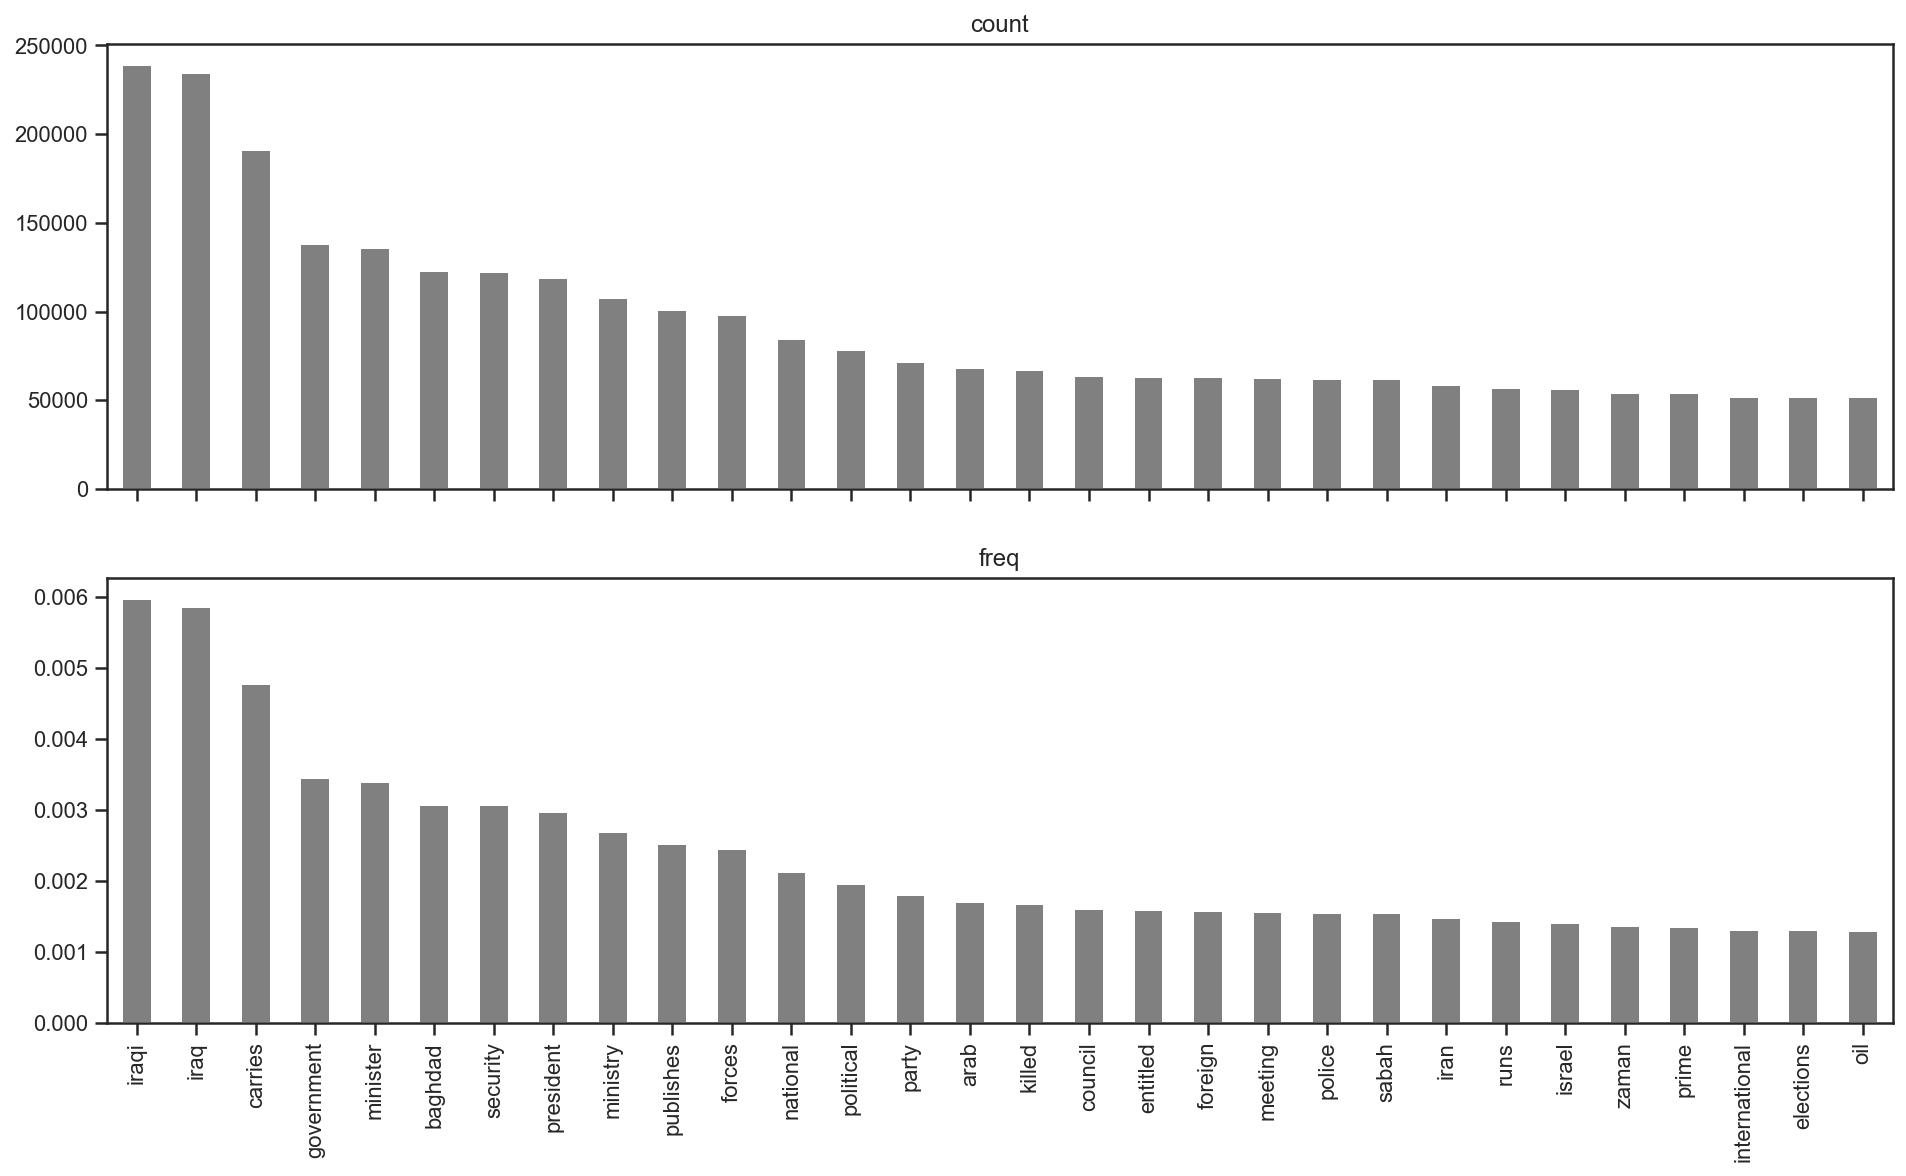

In [10]:
# plot
df_word_counts.head(30).plot.bar(sharex=True, subplots=True, color="grey", legend=False)

# save fig
plt.savefig(
    os.path.join(figure_dir, "BBC_2007_07_04_CORPUS_TEXTACY_{}_WORDCOUNT_N30.png".format(version)), 
    dpi=150,
    bbox_inches="tight"
)

In [11]:
# save
df_word_counts.to_pickle(os.path.join(data_processed, "BBC_2007_07_04_CORPUS_TEXTACY_{}_WORDCOUNT.pkl".format(version)))

### Descriptive statistics II: Word-Document Counts

- *corpus.word_doc_counts*: Map the set of unique words in Corpus to their document counts as absolute, relative, inverse, or binary frequencies of occurence.
- *Returns:* 
- *Note:* The "resulting set of frequencies won’t (necessarily) sum to 1.0, since punctuation and stop words are filtered out after counts are normalized."
- *Weighting:* If **“count”** (default), weights are the absolute number (count) of documents in which word appears. If **“freq”**, word doc counts are normalized by the total document count, giving their relative frequencies of occurrence. If **“idf”**, weights are the log of the inverse relative frequencies: log(n_docs / word_doc_count) or (if smooth_idf is True) log(1 + (n_docs / word_doc_count)) .

smooth_idf – If True, add 1 to all word doc counts when calculating “idf” weighting, equivalent to adding a single document to the corpus containing every unique word.

In [12]:
%%time

# calc
word_doc_counts_wfreq = corpus.word_doc_counts(weighting="freq", as_strings=True)
word_doc_counts_wcount = corpus.word_doc_counts(weighting="count", as_strings=True)
word_doc_counts_widf = corpus.word_doc_counts(weighting="idf", as_strings=True)

# df
df_word_doc_counts_wfreq = pd.DataFrame.from_dict(data=word_doc_counts_wfreq, orient="index", columns=["freq"])
df_word_doc_counts_wcount = pd.DataFrame.from_dict(data=word_doc_counts_wcount, orient="index", columns=["count"])
df_word_doc_counts_widf = pd.DataFrame.from_dict(data=word_doc_counts_widf, orient="index", columns=["idf"])

# merge
if (df_word_doc_counts_wfreq.index == df_word_doc_counts_wcount.index).all():
    df_word_doc_counts = pd.concat([df_word_doc_counts_wcount, df_word_doc_counts_wfreq, df_word_doc_counts_widf], axis=1)
    
# sanity check
assert (df_word_doc_counts.sort_values("count", ascending=False) == df_word_doc_counts.sort_values("freq", ascending=False)).all().all()

# sort
df_word_doc_counts = df_word_doc_counts.sort_values("count", ascending=False)
df_word_doc_counts

CPU times: user 1min, sys: 310 ms, total: 1min 1s
Wall time: 1min 1s


,count,freq,idf
-PRON-,1447,0.958278,0.714683
government,1291,0.854967,0.774559
minister,1222,0.809272,0.804545
national,1198,0.793377,0.815557
president,1169,0.774172,0.829295
...,...,...,...
raymun,1,0.000662,7.320527
sukhna,1,0.000662,7.320527
associati,1,0.000662,7.320527
unfledge,1,0.000662,7.320527


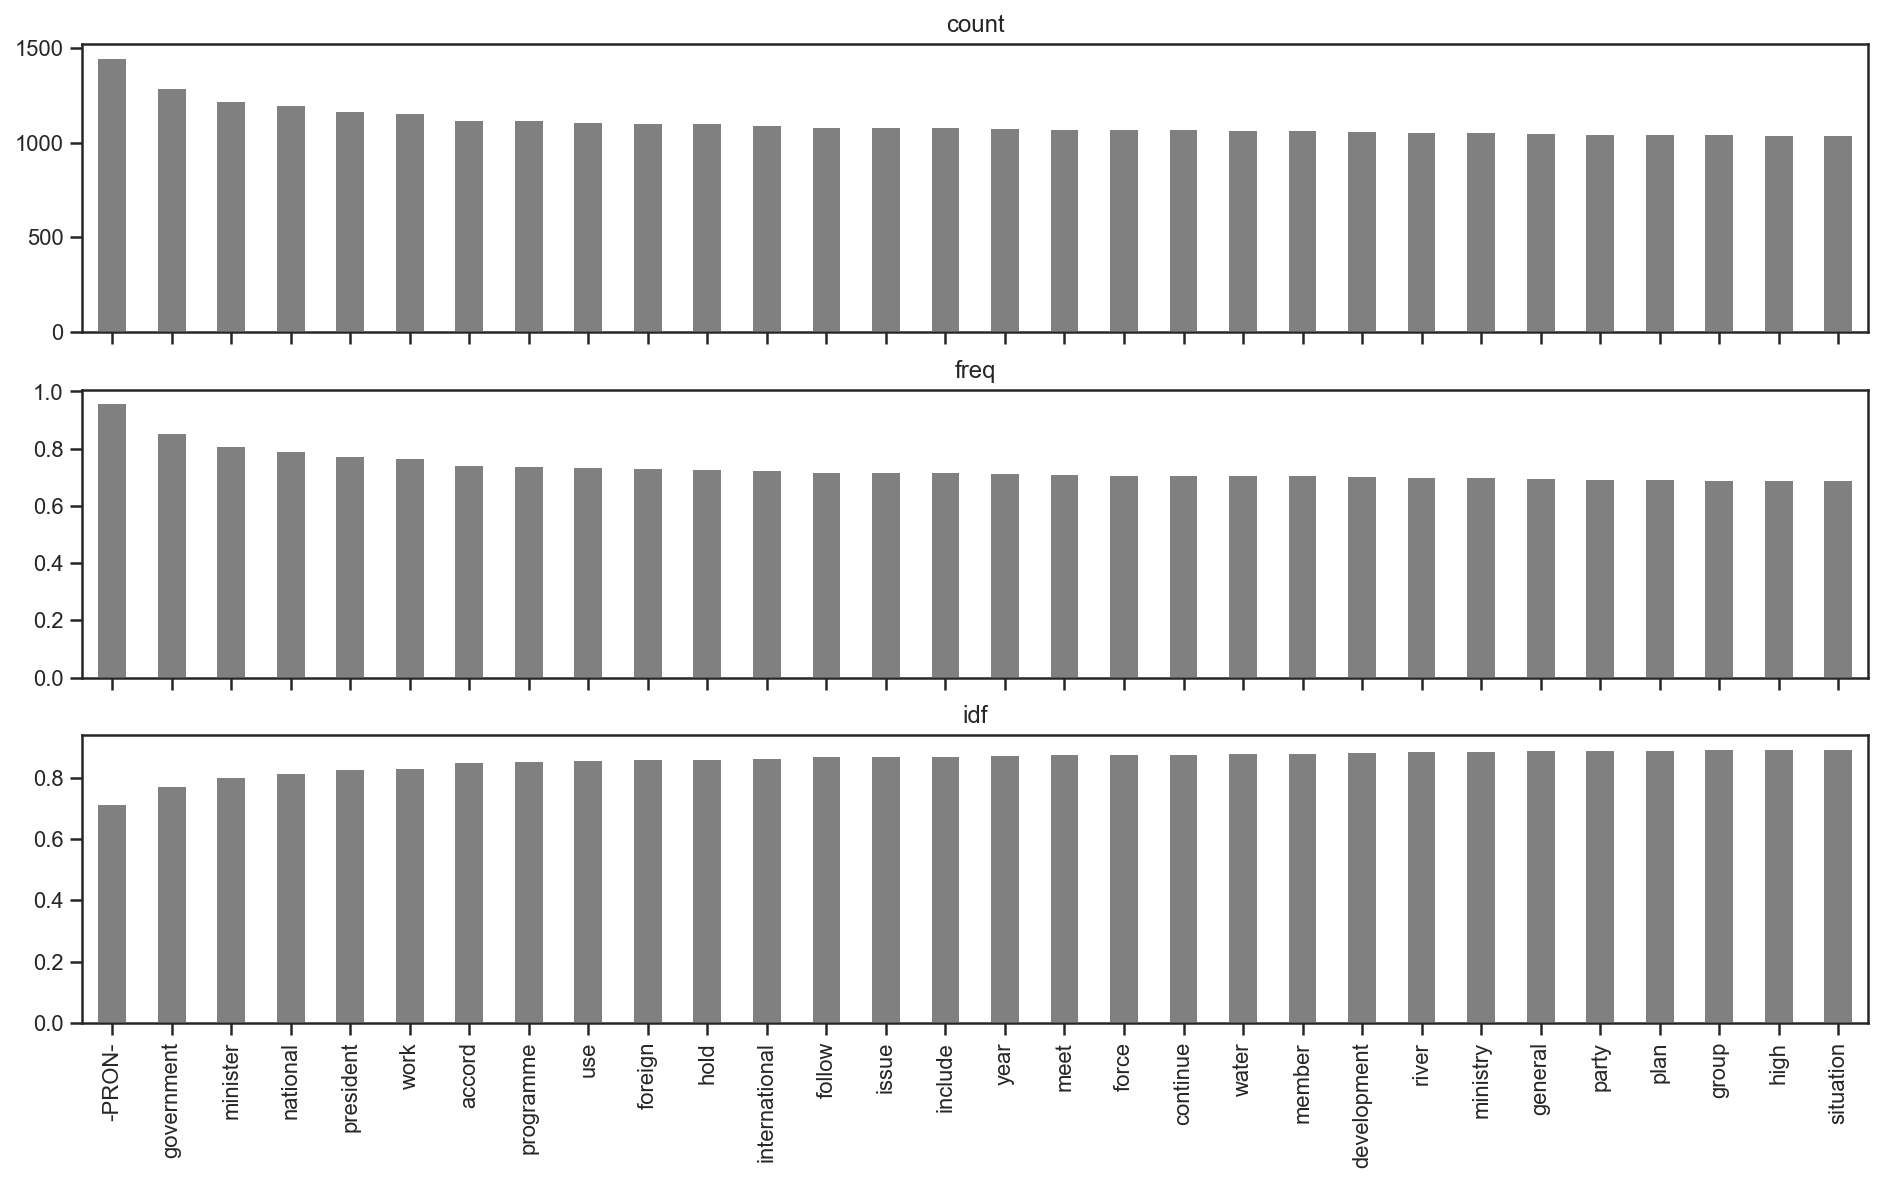

In [13]:
df_word_doc_counts.head(30).plot.bar(sharex=True, subplots=True, color="grey", legend=False)

# save fig
plt.savefig(
    os.path.join(figure_dir, "BBC_2007_07_04_CORPUS_TEXTACY_{}_WORDDOCCOUNT_N30.png".format(version)), 
    dpi=150,
    bbox_inches="tight"
)

In [14]:
# save
df_word_doc_counts.to_pickle(os.path.join(data_processed, "BBC_2007_07_04_CORPUS_TEXTACY_{}_WORDDOCCOUNT.pkl".format(version)))